**классификатор текстов LSTM**

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
tqdm.pandas()

In [4]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [5]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [6]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [7]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [8]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [9]:
data.sample(10)

,id,ttext,ttype
95605,422664957558157312,"@interlicious @Svetlyi уже нет. Но и не мерзость, как северная Европа. А Рим и Барса выходят дорого за всё вместе((",-1
10140,410395785487220736,"Видимо, приветствуя морозы, у меня активизировался хронический гайморит( С противной темпрой и гнусавым голосом в эфире( фак",-1
72653,418163455372587008,"RT @Bulletproof_5: @stringushi я уже побухал, но чета как та фу (((( так чтоо сижу смотрю телик тихонечко",-1
26355,412281633622855681,блин. че за хрень?..позвонил.. теперь не отвечаешь..(,-1
34179,409764109157408768,"-нам дают плов в миске. На месяц\n-по одной рисенке в день? \n-там вообще риса нету, там картинка \nПхахах)",1
8699,410130850983190529,Ну вот допрыгалась! опять голова заболела!(((,-1
17523,409371855569432576,Веселились на танцах)) А я не хотела идти! Хорошо что пошла)),1
67015,410389060088127488,"Сказочная, новогодняя атмосфера.❄ Обожаю этот период.)",1
60650,410282570333831168,"@PinkShinigami скоро на почту все равно идти, заодно и отправишь все 8)",1
14096,409333599302070272,а мне ПОХУЙ на СТАТУС! ЛЮДИ ЛЮБЛЮ ВАС!))) КРУЧЕ ЛЮДЕЙ Я НЕ ВСТРЕЧАЛ В ЖИЗНИ!!!))) С УВАЖЕНИ,1


## очистка данных

In [10]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:02<00:00, 112621.96it/s]


In [11]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [12]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 92621.78it/s] 


In [13]:
data.sample(3)

,id,ttext,ttype,ttext_clean
12566,409314019233636352,RT @kamusik_h: &lt;sexy lips&gt; самый смешной момент сегодняшнего дня..никогда не забыть)) @beka0909 @barnoshaaa,1,"[rt, kamusik, h, lt, sexy, lips, gt, самый, смешной, момент, сегодняшнего, дня, никогда, не, забыть, happysmile, barnoshaaa]"
62062,410299576663703552,"Мне не поверили что мне 23, и я уже не учусь и сказали, что хорошо сохранился %)",1,"[мне, не, поверили, что, мне, digit, и, я, уже, не, учусь, и, сказали, что, хорошо, сохранился]"
40621,409921623299330048,"@gruppa_GS МИР прищурившись готов поздороваться с @gruppa_GS, но только после того, как узнает её отношение к євроінтеграції.\nЩаз тока так!)",1,"[gruppa, gs, мир, прищурившись, готов, поздороваться, с, gruppa, gs, но, только, после, того, как, узнает, её, отношение, к, євроінтеграції, щаз, тока, так]"


In [14]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 351147.43it/s]


In [15]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [16]:
data.sample(3)

,id,ttext,ttype,ttext_clean
206097,421855899876339712,Я уже капец не высыпаюсь(((что дальше то будет...,-1,"[уже, капец, высыпаюсь, sadsmile, что, дальше, будет]"
193057,419357771331809280,ну всеее каждодневные звонки закончились(((,-1,"[всеее, каждодневные, звонки, закончились, sadsmile]"
113867,411219342513033216,"@BlackMello55 надеюсь в академии тоже буду постоянной ведущец ихихи :D а у тебя какими репетициями дни заняты? танцуешь,поёшь ммм??? :)",1,"[надеюсь, академии, тоже, буду, постоянной, ведущец, ихихи, happysmile, тебя, какими, репетициями, дни, заняты, танцуешь, поёшь, ммм, happysmile]"


## словарь

In [17]:
voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
voc = { w:i+1 for i,w in enumerate(voc) }
voc['<pad>']= 0
ppr(voc)

записей: 239 518


In [18]:
voc

{'aaa': 1,
 'aaaa': 2,
 'aaaaa': 3,
 'aaaaaaaaaa': 4,
 'aaaaaaaaaaart': 5,
 'aaaaaahhhhhhwow': 6,
 'aaaasyaaa': 7,
 'aaaats': 8,
 'aaahaahaaaah': 9,
 'aaaidar': 10,
 'aaaiguuul': 11,
 'aaakristya': 12,
 'aaalsusha': 13,
 'aaarrrrrrrr': 14,
 'aaaw': 15,
 'aaburnashov': 16,
 'aafrolova': 17,
 'aakarimova': 18,
 'aakellah': 19,
 'aakuzichev': 20,
 'aaleksandra': 21,
 'aaleksandrowna': 22,
 'aalello': 23,
 'aalexithymiaa': 24,
 'aalistok': 25,
 'aalive': 26,
 'aallanavaz': 27,
 'aalove': 28,
 'aammmmmmmm': 29,
 'aamnastya': 30,
 'aamooorr': 31,
 'aamy': 32,
 'aanaokay': 33,
 'aanastasiaden': 34,
 'aandrushkas': 35,
 'aanechaev': 36,
 'aanjkaa': 37,
 'aanneeeet': 38,
 'aannybarry': 39,
 'aanvarova': 40,
 'aanxaa': 41,
 'aapogodina': 42,
 'aarn': 43,
 'aaronpaul': 44,
 'aasexuality': 45,
 'aashirokov': 46,
 'aasokol': 47,
 'aasviridova': 48,
 'aatemkin': 49,
 'aavsasha': 50,
 'aavst': 51,
 'aaw': 52,
 'aaww': 53,
 'aaxaxaax': 54,
 'aayra': 55,
 'aazbaeva': 56,
 'abachurin': 57,
 'abaevart': 

## строим датасет

In [19]:
# заменяем слова на номера в словаре
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 226831/226831 [00:00<00:00, 231489.15it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
159154,"@Mrs_wild_leek я даже боюсь это вслух произносить, потому что все еще сомневаюсь=((","[mrs, wild, leek, даже, боюсь, это, вслух, произносить, потому, что, все, еще, сомневаюсь, sadsmile]","[39930, 64692, 32390, 98262, 80392, 237045, 89445, 183981, 177598, 232369, 89214, 107138, 204062, 51505]"
150039,За маленьких Норка замолвите слово! Много страшных картинок из жизни норок :( Мну опечален до невозможности.,"[маленьких, норка, замолвите, слово, много, страшных, картинок, жизни, норок, sadsmile, мну, опечален, невозможности]","[136304, 152184, 112276, 201381, 140575, 208384, 122381, 108252, 152281, 51505, 140685, 157779, 148133]"
201401,сегодня Землю накроет мощная\nмагнитная буря.ну все пизда нам ребятки:(,"[сегодня, землю, накроет, мощная, магнитная, буря, все, пизда, нам, ребятки, sadsmile]","[197699, 115601, 145217, 142057, 135741, 81757, 89214, 167440, 145427, 191458, 51505]"


In [21]:
# оценка длины последовательностей
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

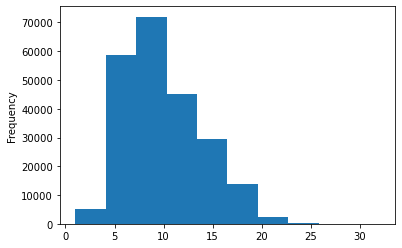

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длинна
code_max_len = data['code'].str.len().max()
code_max_len

32

In [24]:
# выравниваем длину последовательностей
z = [0]*code_max_len # дополняем нулями короткие последовательности
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 323111.25it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    226831
mean         32
std           0
min          32
25%          32
50%          32
75%          32
max          32
Name: code, dtype: int64

---

In [26]:
# собираем матрицу датасета
x = np.stack( data['code'].values).astype(int)

# для повышения эффективности работы рекуррентной модели
# переворачиваем последовательности, 
# код первого слова в конце, 
# нули дополнения в начале
x = np.flip(x,axis=1)

x.shape

(226831, 32)

In [27]:
# метка класса {0,1}
n_classes = 2 # количество классов
y = (data['ttype'].values+1) // 2
y.shape

(226831,)

In [28]:
max_word = x.max() # максимальный номер слова
seq_len = x.shape[1] # длина последовательности

max_word, seq_len

(239517, 32)

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32), (136098,), (90733, 32), (90733,))

In [30]:
# количество позитивных примеров в train и test наборах
y_train.sum(axis=0),y_test.sum(axis=0),

(68682, 46227)

In [31]:
def get_batch(x,y,batch_size=512):
    n = x.shape[0] # количество примеров
    pt = int(np.ceil(n/batch_size)) # количество батчей
    
    # случайным образом мешаем примеры и режем на батчи
    ii = rng.permutation(n)
    xr,yr = np.array_split(x[ii,:],pt), np.array_split(y[ii],pt)
    
    for i in range(pt): # генератор выдаёт батчи
        yield i,xr[i],yr[i]

In [32]:
# batches = get_batch(x_train,y_train,batch_size=512)    

In [33]:
# for i,xb,yb in batches: 
#     print(i,xb.shape)

## строим модель

In [34]:
embedding_dim = 64 # размер выхода эмбединга
hidden_dim = 32 # размер рекуррентного слоя

In [35]:
class Model(nn.Module):
    def __init__(self, 
                 num_embeddings=max_word+1, # размер входа эмбединга (длина OHE)
                 emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        out = self.sftm(out)
        return out 

In [36]:
model = Model()
model

Model(
  (emb): Embedding(239518, 64)
  (rnn): LSTM(64, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

In [37]:
# z = torch.zeros( size=(1,seq_len), dtype=torch.int, requires_grad=False)
# out = model(z)
# make_dot( out, params=dict(list(model.named_parameters())), ) #show_attrs=True )  
# # .render("rnn_torchviz", format="png")

## обучаем модель

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
model = model.to(device)

In [40]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [41]:
%%time

epochs = 9
hist = []
for i in range(epochs):
    batches = get_batch(x_train,y_train,batch_size=1024)    
    
    for j,xb,yb in batches: 
        
        xt,yt = torch.tensor(xb).to(device), torch.tensor(yb).to(device)
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xt) # вычисляем выход, прямой проход
        loss = loss_function(out,yt) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
        del xt
        del yt
       

    #if((i%3)==1): print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')


epoch:   0 loss: 0.43348715
epoch:   1 loss: 0.39865962
epoch:   2 loss: 0.38118887
epoch:   3 loss: 0.36939713
epoch:   4 loss: 0.37430423
epoch:   5 loss: 0.36848286
epoch:   6 loss: 0.36145508
epoch:   7 loss: 0.36106700
epoch:   8 loss: 0.35810837
CPU times: user 17.6 s, sys: 189 ms, total: 17.8 s
Wall time: 18 s


In [42]:
torch.cuda.empty_cache()

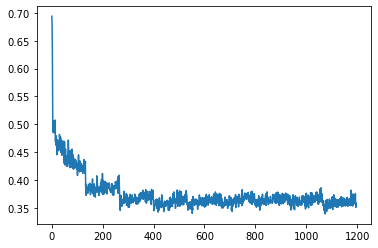

In [43]:
# изменение значения потери в процессе обучения
plt.plot(hist)

## тест

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [45]:
xt = torch.tensor(x_test).to(device)
out = model(xt)
scores = out.cpu().detach().numpy()
y_pred = np.argmax( scores ,axis=1)

In [46]:
del xt
torch.cuda.empty_cache()

In [47]:
accuracy_score(y_test, y_pred)

0.8723066579965393

In [48]:
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     44506
           1       0.90      0.84      0.87     46227

    accuracy                           0.87     90733
   macro avg       0.87      0.87      0.87     90733
weighted avg       0.87      0.87      0.87     90733



----

In [54]:
# from matplotlib import pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense

# embedding_size = 64

# model = Sequential()
# model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
# model.add(LSTM(32))
# model.add(Dense(n_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])


# hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

# model.evaluate( x_test ,y_test )

# k = hist.history.keys()
# w,h = 6,4
# fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
# for i,n in enumerate(k):
#     ax[i].plot(hist.history[n],label=n)
#     ax[i].grid(True)
#     ax[i].legend()
#     ax[i].set_ylim([-.1,1.1])